In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import scipy.io.wavfile
import copy

plt.style.use(['science', 'notebook'])



---
VIDEO: Fourier transform for spectral analyses
---


In [2]:
## Generate a multispectral noisy signal

# simulation parameters
srate = 2054  # in Hz
npnts = srate * 2  # 2 seconds
time = np.arange(0, npnts) / srate

# frequencies to include
frex = [12, 18, 30]

signal = np.zeros(len(time))

# loop over frequencies to create signal
for fi in range(0, len(frex)):
    signal = signal + (fi + 1) * np.sin(2 * np.pi * frex[fi] * time)

# add some noise
signal = signal + np.random.randn(len(signal))

# amplitude spectrum via Fourier transform
signalX = scipy.fftpack.fft(signal)
signalAmp = 2 * np.abs(signalX) / npnts

# vector of frequencies in Hz
hz = np.linspace(0, srate / 2, int(np.floor(npnts / 2) + 1))


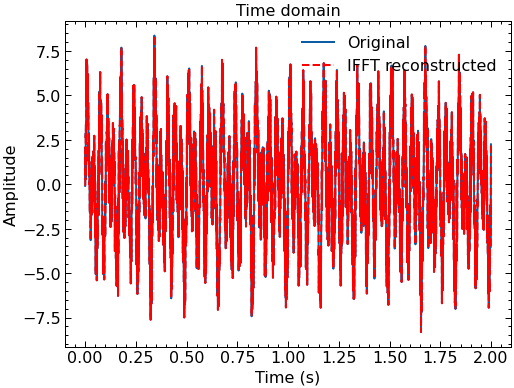

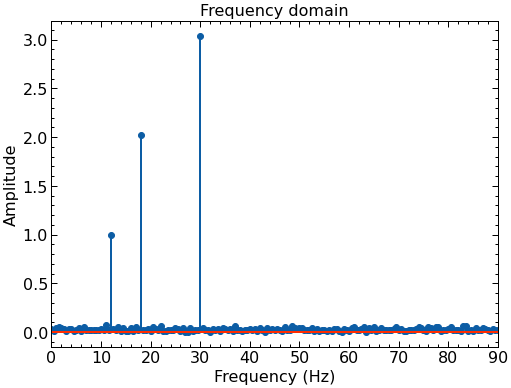

In [3]:
## plots

plt.plot(time, signal, label="Original")
plt.plot(time, np.real(scipy.fftpack.ifft(signalX)), "r--", label="IFFT reconstructed")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time domain")
plt.legend()
plt.show()

plt.stem(hz, signalAmp[0 : len(hz)])
plt.xlim([0, np.max(frex) * 3])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency domain")
plt.show()


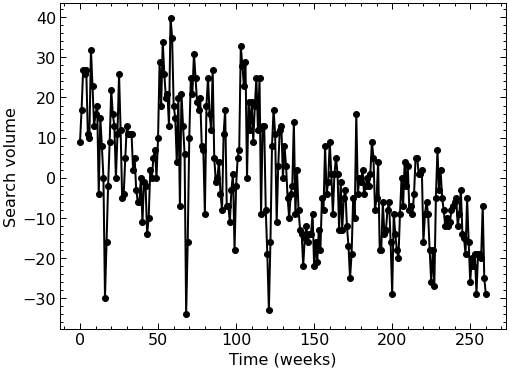

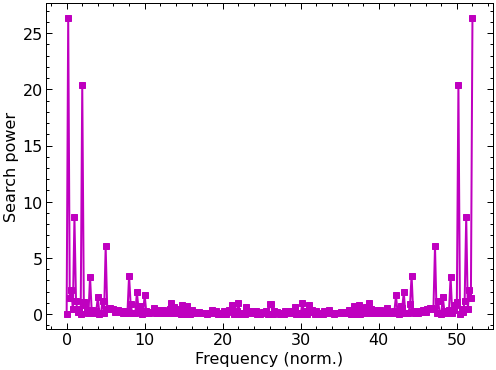

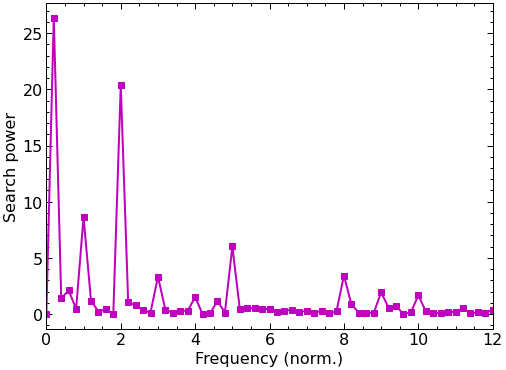

In [4]:
## example with real data

# data downloaded from https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=signal%20processing
searchdata = [
    69,
    77,
    87,
    86,
    87,
    71,
    70,
    92,
    83,
    73,
    76,
    78,
    56,
    75,
    68,
    60,
    30,
    44,
    58,
    69,
    82,
    76,
    73,
    60,
    71,
    86,
    72,
    55,
    56,
    65,
    73,
    71,
    71,
    71,
    62,
    65,
    57,
    54,
    54,
    60,
    49,
    59,
    58,
    46,
    50,
    62,
    60,
    65,
    67,
    60,
    70,
    89,
    78,
    94,
    86,
    80,
    81,
    73,
    100,
    95,
    78,
    75,
    64,
    80,
    53,
    81,
    73,
    66,
    26,
    44,
    70,
    85,
    81,
    91,
    85,
    79,
    77,
    80,
    68,
    67,
    51,
    78,
    85,
    76,
    72,
    87,
    65,
    59,
    60,
    64,
    56,
    52,
    71,
    77,
    53,
    53,
    49,
    57,
    61,
    42,
    58,
    65,
    67,
    93,
    88,
    83,
    89,
    60,
    79,
    72,
    79,
    69,
    78,
    85,
    72,
    85,
    51,
    73,
    73,
    52,
    41,
    27,
    44,
    68,
    77,
    71,
    49,
    63,
    72,
    73,
    60,
    68,
    63,
    55,
    50,
    56,
    58,
    74,
    51,
    62,
    52,
    47,
    46,
    38,
    45,
    48,
    44,
    46,
    46,
    51,
    38,
    44,
    39,
    47,
    42,
    55,
    52,
    68,
    56,
    59,
    69,
    61,
    51,
    61,
    65,
    61,
    47,
    59,
    47,
    55,
    57,
    48,
    43,
    35,
    41,
    55,
    50,
    76,
    56,
    60,
    59,
    62,
    56,
    58,
    60,
    58,
    61,
    69,
    65,
    52,
    55,
    64,
    42,
    42,
    54,
    46,
    47,
    52,
    54,
    44,
    31,
    51,
    46,
    42,
    40,
    51,
    60,
    53,
    64,
    58,
    63,
    52,
    53,
    51,
    56,
    65,
    65,
    61,
    61,
    62,
    44,
    51,
    54,
    51,
    42,
    34,
    42,
    33,
    55,
    67,
    57,
    62,
    55,
    52,
    48,
    50,
    48,
    49,
    52,
    53,
    54,
    55,
    48,
    51,
    57,
    46,
    45,
    41,
    55,
    44,
    34,
    40,
    38,
    41,
    31,
    41,
    41,
    40,
    53,
    35,
    31,
]
N = len(searchdata)

# possible normalizations...
searchdata = searchdata - np.mean(searchdata)

# power
searchpow = np.abs(scipy.fftpack.fft(searchdata) / N) ** 2
hz = np.linspace(0, 52, N)

plt.plot(searchdata, "ko-")
plt.xlabel("Time (weeks)")
plt.ylabel("Search volume")
plt.show()

plt.plot(hz, searchpow, "ms-")
plt.xlabel("Frequency (norm.)")
plt.ylabel("Search power")
plt.show()

plt.plot(hz, searchpow, "ms-")
plt.xlabel("Frequency (norm.)")
plt.ylabel("Search power")
plt.xlim([0, 12])
plt.show()



---
# VIDEO: Welch's method
---


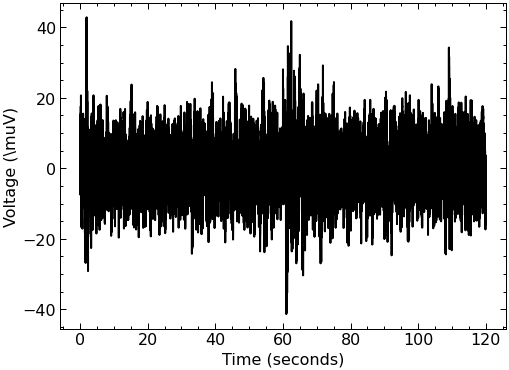

In [5]:
# load data and extract
matdat = sio.loadmat("EEGrestingState.mat")
eegdata = matdat["eegdata"][0]
srate = matdat["srate"][0]

# time vector
N = len(eegdata)
timevec = np.arange(0, N) / srate

# plot the data
plt.plot(timevec, eegdata, "k")
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage (\muV)")
plt.show()


In [6]:
## one big FFT (not Welch's method)

# "static" FFT over entire period, for comparison with Welch
eegpow = np.abs(scipy.fftpack.fft(eegdata) / N) ** 2
hz = np.linspace(0, srate / 2, int(np.floor(N / 2) + 1))


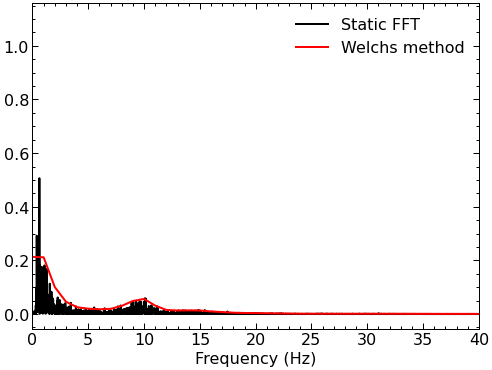

In [7]:
## "manual" Welch's method

# window length in seconds*srate
winlength = int(1 * srate)

# number of points of overlap
nOverlap = np.round(srate / 2)

# window onset times
winonsets = np.arange(0, int(N - winlength), int(nOverlap))

# note: different-length signal needs a different-length Hz vector
hzW = np.linspace(0, srate / 2, int(np.floor(winlength / 2) + 1))

# Hann window
hannw = 0.5 - np.cos(2 * np.pi * np.linspace(0, 1, int(winlength))) / 2

# initialize the power matrix (windows x frequencies)
eegpowW = np.zeros(len(hzW))

# loop over frequencies
for wi in range(0, len(winonsets)):

    # get a chunk of data from this time window
    datachunk = eegdata[winonsets[wi] : winonsets[wi] + winlength]

    # apply Hann taper to data
    datachunk = datachunk * hannw

    # compute its power
    tmppow = np.abs(scipy.fftpack.fft(datachunk) / winlength) ** 2

    # enter into matrix
    eegpowW = eegpowW + tmppow[0 : len(hzW)]

# divide by N
eegpowW = eegpowW / len(winonsets)


# plotting
plt.plot(hz, eegpow[0 : len(hz)], "k", label="Static FFT")
plt.plot(hzW, eegpowW / 10, "r", label="Welch" "s method")
plt.xlim([0, 40])
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()


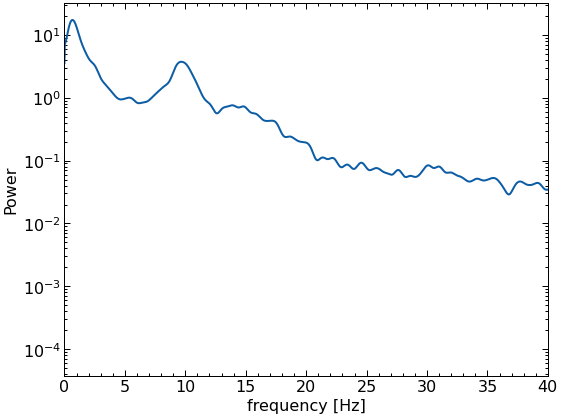

In [8]:
## Python's welch

# create Hann window
winsize = int(2 * srate)  # 2-second window
hannw = 0.5 - np.cos(2 * np.pi * np.linspace(0, 1, winsize)) / 2

# number of FFT points (frequency resolution)
nfft = srate * 100

f, welchpow = scipy.signal.welch(
    eegdata, fs=srate, window=hannw, nperseg=winsize, noverlap=winsize / 4, nfft=nfft
)

plt.figure()
plt.semilogy(f, welchpow)
plt.xlim([0, 40])
plt.xlabel("frequency [Hz]")
plt.ylabel("Power")
plt.tight_layout()
plt.show()



---
# VIDEO: Spectrogram of birdsong
---


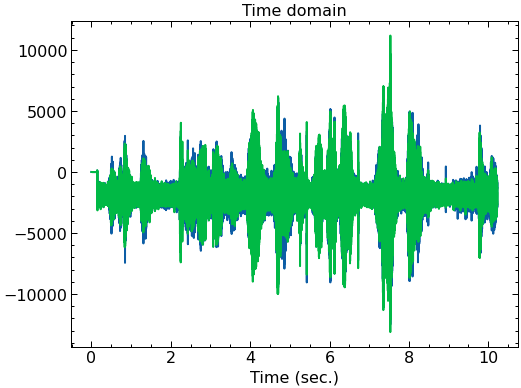

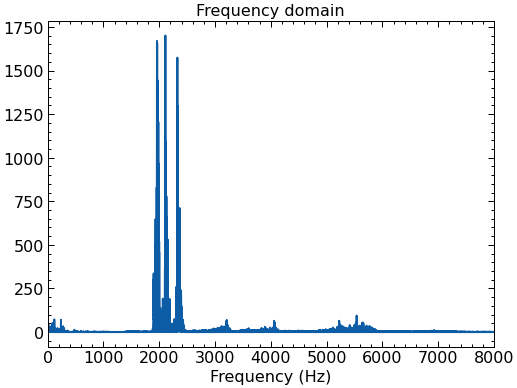

In [9]:
## load in birdcall (source: https://www.xeno-canto.org/403881)

fs, bc = scipy.io.wavfile.read("XC403881.wav")


# create a time vector based on the data sampling rate
n = len(bc)
timevec = np.arange(0, n) / fs

# plot the data from the two channels
plt.figure()
plt.plot(timevec, bc)
plt.xlabel("Time (sec.)")
plt.title("Time domain")
plt.show()

# compute the power spectrum
hz = np.linspace(0, fs / 2, int(np.floor(n / 2) + 1))
bcpow = np.abs(scipy.fftpack.fft(scipy.signal.detrend(bc[:, 0])) / n) ** 2

# now plot it
plt.figure()
plt.plot(hz, bcpow[0 : len(hz)])
plt.xlabel("Frequency (Hz)")
plt.title("Frequency domain")
plt.xlim([0, 8000])
plt.show()


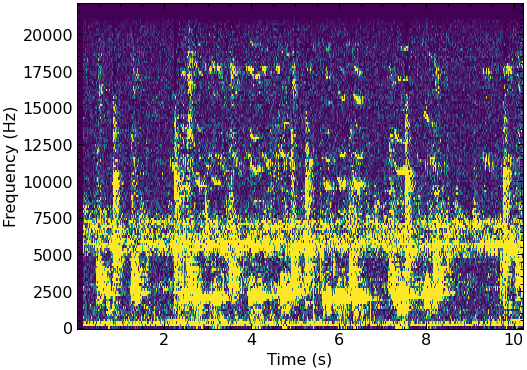

In [10]:
## time-frequency analysis via spectrogram

frex, time, pwr = scipy.signal.spectrogram(bc[:, 0], fs)

plt.pcolormesh(time, frex, pwr, vmin=0, vmax=9)
plt.xlabel("Time (s)"), plt.ylabel("Frequency (Hz)")
plt.show()
